# **Globals**

In [284]:
letters = [
    "أ",
    "ب",
    "ت",
    "ث",
    "ج",
    "ح",
    "خ",
    "د",
    "ذ",
    "ر",
    "ز",
    "س",
    "ش",
    "ص",
    "ض",
    "ط",
    "ظ",
    "ع",
    "غ",
    "ف",
    "ق",
    "ك",
    "ل",
    "م",
    "ن",
    "هـ",
    "و",
    "ئ",
    "ة",
    "ال",
    "لا",
    "ي", 
]

len(letters)

32

In [285]:
labels_dic = {
    "aleff": 0, #أ
    "bb": 1,    #ب
    "taa": 2,   #ت
    "thaa": 3,  #ث
    "jeem": 4,  #ج
    "haa": 5,   #ح
    "khaa": 6,  #خ
    "dal": 7,   #د
    "thal": 8,  #ذ
    "ra": 9,    #ر
    "zay": 10,  #ز
    "seen": 11, #س
    "sheen": 12,    #ش
    "saad": 13, #ص
    "dhad": 14, #ض
    "ta": 15,   #ط
    "dha": 16,  #ظ
    "ain": 17,  #ع
    "ghain": 18,    #غ
    "fa": 19,   #ف
    "gaaf": 20, #ق
    "kaaf": 21, #ك
    "laam": 22, #ل
    "meem": 23, #م
    "nun": 24,  #ن
    "ha": 25,   #هـ
    "waw": 26,  #و
    "ya": 27,   #ئ
    "toot": 28, #ة
    "al": 29,   #ال
    "la": 30,   #لا
    "yaa": 31   #ي
}

# **Model**

## *1. Base Model*

In [286]:
import torch
from torch.nn import Linear, ReLU
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Sequential, global_mean_pool, global_max_pool

class GCN(torch.nn.Module):
    def __init__(self, num_features, classes, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 128)
        self.conv4 = GCNConv(128, 64)
        self.lin = Linear(64, classes)

    def forward(self, x, edge_index, batchh):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        # 2. Readout layer
        x = global_max_pool(x, batchh)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [287]:
testing_model = GCN(2, classes=len(letters), hidden_channels=64)

best_checkpoint = torch.load("weights/weights_img_gcn_c32_v3.tar")

testing_model.load_state_dict(best_checkpoint["model_state_dict"])

<All keys matched successfully>

# *2. Graph Generator*

In [288]:
import mediapipe as mp

class GraphGenerator:
    __model = mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    
    def __init__(self):
        self.__edges = list()
        mp_holistic = mp.solutions.holistic
        for edge in mp_holistic.HAND_CONNECTIONS:
            self.__edges.append(list(edge))

    def generate_graph_features(self, image):
        flag, kp = self.__extract_keypoints(image)
        if not flag:
            return False, None, None
        
        return True, self.__node_features_extraction(kp), self.__edges

    def __extract_keypoints(self, img):
        image = img.copy()
        results = self.__mediapipe_detection(image)

        left_flag = results.left_hand_landmarks
        right_flag = results.right_hand_landmarks

        if left_flag:
            return True, np.array([ [res.x, res.y] for res in results.left_hand_landmarks.landmark ]).flatten()
        elif right_flag:
            return True, np.array([ [res.x, res.y] for res in results.right_hand_landmarks.landmark ]).flatten()
        else:
            return False, None

    def __mediapipe_detection(self, image):
        image  = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = GraphGenerator.__model.process(image)
        image.flags.writeable = True
        image  = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        return results

    def __node_features_extraction(self, kp):
        node_features = list()
        for i in range(0, len(kp), 2):
            node_features.append([kp[i], kp[i+1]])
        
        return node_features

In [289]:
import cv2
import numpy as np


dir_path = os.path.join("letters recognition", "collected_images_v2", "all_images", "all_of_the_images")

graph_generator = GraphGenerator()
images = os.listdir(dir_path)[::2]

frame = cv2.imread(os.path.join(dir_path, images[401]))

flag, node_features, edges = graph_generator.generate_graph_features(frame)
len(edges)

21

## *3. Predictor Class*

In [290]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

class Predictor:
    def __init__(self, model):
        self.model = model
        self.graph_generator = GraphGenerator()

    def __preprocess(self, image):
        flag, node_features, edges = self.graph_generator.generate_graph_features(image)
        if not flag:
            return None
        edge_index = torch.tensor(edges, dtype=torch.long)
        x = torch.tensor(node_features, dtype=torch.float)
        return Data(x=x, edge_index=edge_index.t().contiguous())

    def predict(self, image):
        graph = self.__preprocess(image)
        if graph is None:
            return None
        # data_dl = DataLoader([graph], batch_size=256)
        # data = next(iter(data_dl))
        # print(data.batch.dtype)
        # print(graph)
        # pred = self.model(data.x, data.edge_index, data.batch)
        batch = torch.zeros(21, dtype=torch.int64)
        with torch.no_grad():
            self.model.eval()
            pred = self.model(graph.x, graph.edge_index, batch)
        return pred

# **Testing on new data**

## *1. Model on 80830 epoch*

In [291]:
result = dict()
total_images = 0

In [292]:
dir_path = os.path.join("letters recognition", "collected_images_v9", "image")
lets = os.listdir(dir_path)
images = os.listdir(dir_path)[::2]

predictor = Predictor(testing_model)

if len(result) == 0 and total_images == 0:
    result = dict()
    total_images = 0

for letter in lets:
    for folder in ["right", "left"]:
        folder_path = os.path.join(dir_path, letter, folder)
        images = os.listdir(folder_path)
        for img_name in images:
            frame = cv2.imread(os.path.join(folder_path, img_name))
            img_name = img_name.split("_")[0]
            if img_name not in result:
                result[img_name] = {"true": 0, "false": 0, "total": 0}
            gr_truth = labels_dic[img_name]
            pred = predictor.predict(frame)
            if pred is not None:
                total_images += 1
                result[img_name]["total"] += 1
                pred = pred.argmax().item()
                if pred == gr_truth:
                    result[img_name]["true"] += 1
                else:
                    result[img_name]["false"] += 1
                print(gr_truth, pred)

17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 6
17 5
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 6
17 17
17 17
17 17
17 17
17 17
17 17
17 26
17 17
17 6
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 13
17 18
17 17
17 20
17 7
17 17
17 17
17 17
17 17
17 17
17 17
17 27
17 27
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
17 17
29 18
29 29
29 28
29 17
29 29
29 29
29 29
29 29
29 29
29 29
29 15
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 19
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 21
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 31
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 29
29 21
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 4
0 0
0 0
0 0
0 0
0 0
0 15
0 0
0 0
0 0
0 0
0 3
0 0
0 0
0 0
0 0
0 15
0 0
0 0
0 17
0 0
0 0
0 0
0 0
0 0
0 

In [293]:
result

{'ain': {'true': 64, 'false': 11, 'total': 75},
 'al': {'true': 61, 'false': 8, 'total': 69},
 'aleff': {'true': 82, 'false': 12, 'total': 94},
 'bb': {'true': 95, 'false': 2, 'total': 97},
 'dal': {'true': 58, 'false': 13, 'total': 71},
 'dha': {'true': 60, 'false': 13, 'total': 73},
 'dhad': {'true': 63, 'false': 4, 'total': 67},
 'fa': {'true': 64, 'false': 11, 'total': 75},
 'gaaf': {'true': 50, 'false': 20, 'total': 70},
 'ghain': {'true': 53, 'false': 20, 'total': 73},
 'ha': {'true': 60, 'false': 12, 'total': 72},
 'haa': {'true': 56, 'false': 12, 'total': 68},
 'jeem': {'true': 79, 'false': 9, 'total': 88},
 'kaaf': {'true': 58, 'false': 3, 'total': 61},
 'khaa': {'true': 63, 'false': 10, 'total': 73},
 'la': {'true': 60, 'false': 8, 'total': 68},
 'laam': {'true': 64, 'false': 10, 'total': 74},
 'meem': {'true': 62, 'false': 9, 'total': 71},
 'nun': {'true': 62, 'false': 10, 'total': 72},
 'ra': {'true': 66, 'false': 13, 'total': 79},
 'saad': {'true': 50, 'false': 14, 'total'

In [294]:
total_true = 0
total_false = 0
for key in result:
    total_true += result[key]["true"]
    total_false += result[key]["false"]

print(f"Total Images: {total_images}, True Images: {total_true}, False Images: {total_false}, Pers.: {(total_true/total_images)*100}")

Total Images: 2388, True Images: 2068, False Images: 320, Pers.: 86.59966499162479


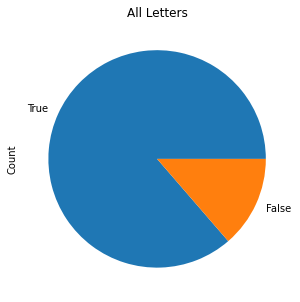

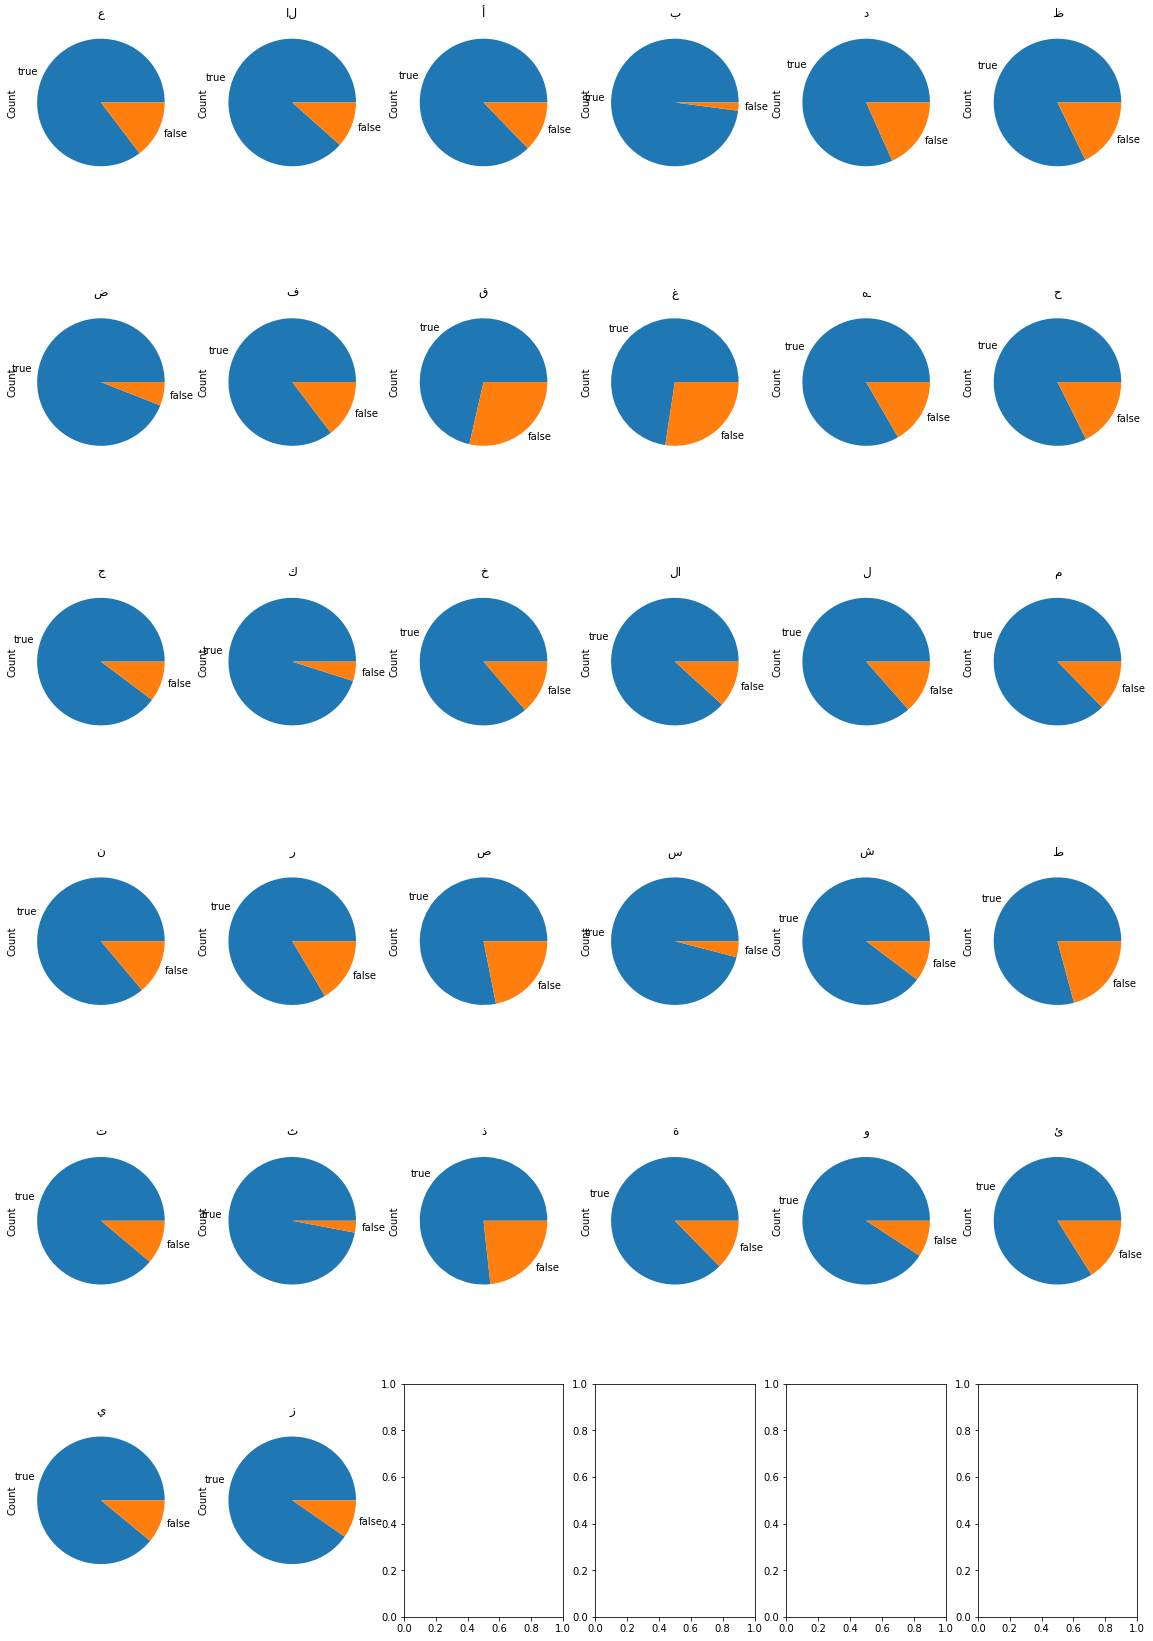

In [295]:
from matplotlib import pyplot as plt
import pandas as pd

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
stat = pd.Series(data={"True": 2062, "False": 326})
stat.plot(kind="pie", title="All Letters", ylabel="Count")

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 30))
i, j = 0, 0
for key in result:
    s = pd.Series(data=result[key])
    s.plot(kind="pie", title=letters[labels_dic[key]], ylabel="Count", ax=axes[i][j])
    j += 1
    if j == 6:
        j = 0
        i += 1


## *1. Model on 100000 epoch*

In [ ]:
result = dict()
total_images = 0

In [ ]:
dir_path = os.path.join("letters recognition", "collected_images_v9", "image")
lets = os.listdir(dir_path)
images = os.listdir(dir_path)[::2]

predictor = Predictor(testing_model)

if len(result) == 0 and total_images == 0:
    result = dict()
    total_images = 0

for letter in lets:
    for folder in ["right", "left"]:
        folder_path = os.path.join(dir_path, letter, folder)
        images = os.listdir(folder_path)
        for img_name in images:
            frame = cv2.imread(os.path.join(folder_path, img_name))
            img_name = img_name.split("_")[0]
            if img_name not in result:
                result[img_name] = {"true": 0, "false": 0, "total": 0}
            gr_truth = labels_dic[img_name]
            pred = predictor.predict(frame)
            if pred is not None:
                total_images += 1
                result[img_name]["total"] += 1
                pred = pred.argmax().item()
                if pred == gr_truth:
                    result[img_name]["true"] += 1
                else:
                    result[img_name]["false"] += 1
                print(gr_truth, pred)

In [218]:
result

{'ain': {'true': 60, 'false': 15, 'total': 75},
 'al': {'true': 62, 'false': 7, 'total': 69},
 'aleff': {'true': 81, 'false': 12, 'total': 93},
 'bb': {'true': 96, 'false': 1, 'total': 97},
 'dal': {'true': 57, 'false': 11, 'total': 68},
 'dha': {'true': 67, 'false': 6, 'total': 73},
 'dhad': {'true': 62, 'false': 5, 'total': 67},
 'fa': {'true': 64, 'false': 11, 'total': 75},
 'gaaf': {'true': 45, 'false': 22, 'total': 67},
 'ghain': {'true': 56, 'false': 18, 'total': 74},
 'ha': {'true': 67, 'false': 5, 'total': 72},
 'haa': {'true': 51, 'false': 15, 'total': 66},
 'jeem': {'true': 77, 'false': 12, 'total': 89},
 'kaaf': {'true': 60, 'false': 8, 'total': 68},
 'khaa': {'true': 61, 'false': 12, 'total': 73},
 'la': {'true': 58, 'false': 10, 'total': 68},
 'laam': {'true': 64, 'false': 10, 'total': 74},
 'meem': {'true': 63, 'false': 8, 'total': 71},
 'nun': {'true': 62, 'false': 10, 'total': 72},
 'ra': {'true': 64, 'false': 15, 'total': 79},
 'saad': {'true': 50, 'false': 14, 'total'

In [232]:
total_true = 0
total_false = 0
for key in result:
    total_true += result[key]["true"]
    total_false += result[key]["false"]

print(f"Total Images: {total_images}, True Images: {total_true}, False Images: {total_false}, Pers.: {(total_true/total_images)*100}")

Total Images: 2388, True Images: 2062, False Images: 326, Pers.: 86.34840871021775


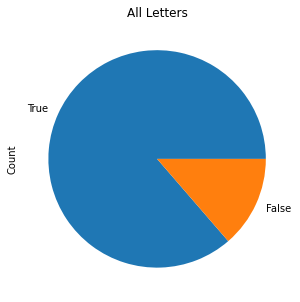

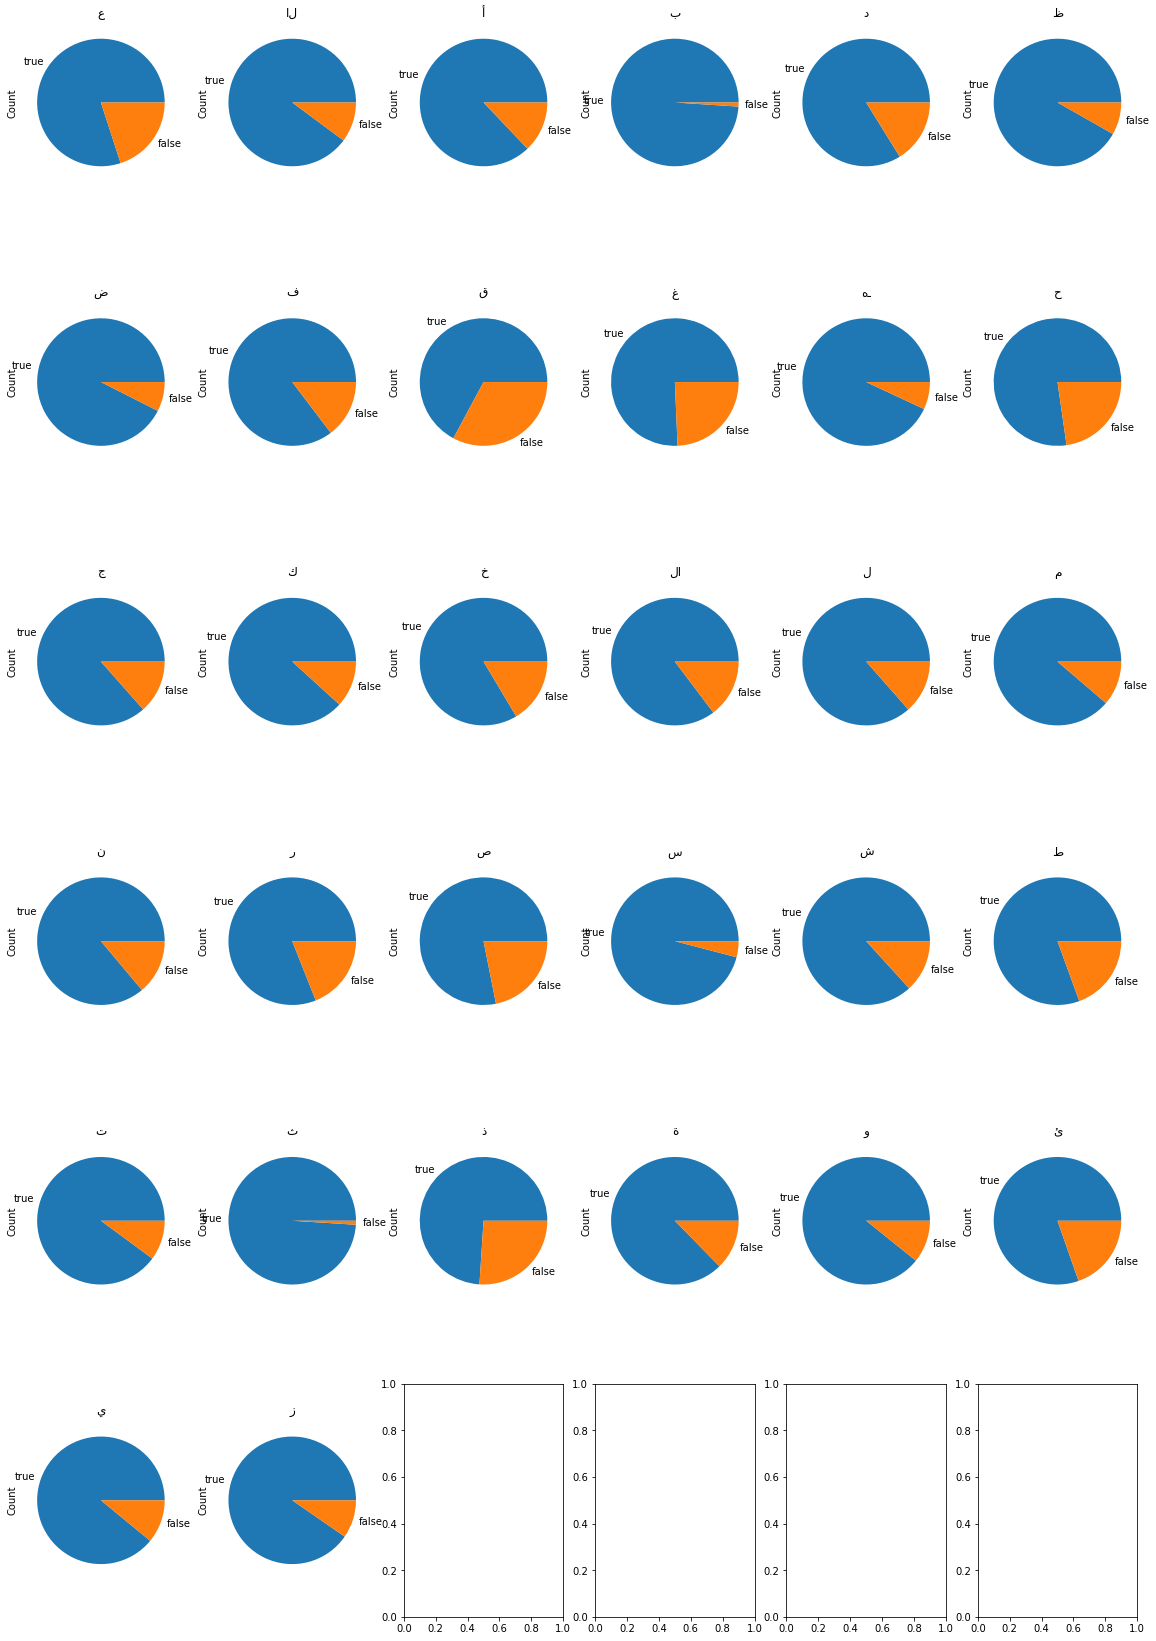

In [282]:
from matplotlib import pyplot as plt
import pandas as pd

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
stat = pd.Series(data={"True": 2062, "False": 326})
stat.plot(kind="pie", title="All Letters", ylabel="Count")

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 30))
i, j = 0, 0
for key in result:
    s = pd.Series(data=result[key])
    s.plot(kind="pie", title=letters[labels_dic[key]], ylabel="Count", ax=axes[i][j])
    j += 1
    if j == 6:
        j = 0
        i += 1
